In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.models import resnet50
from tqdm.notebook import tqdm

sns.set_theme()

In [3]:
from nircoloring.dataset.downloader import SerengetiMetaDataSource
from nircoloring.evaluation.config import *

In [4]:
meta_data_source = SerengetiMetaDataSource()


def load_labels():
    annotations = meta_data_source.load_annotations()
    return annotations.groupby("image_id")["category_id"].unique()


def load_images():
    images = meta_data_source.load_images()
    images["base_file_name"] = images["file_name"].apply(lambda filename: PosixPath(filename).stem).str.lower()
    return images[["id", "base_file_name"]].set_index("base_file_name")


images = load_images()
labels = load_labels()

In [5]:
categories = meta_data_source.load_categories()

In [6]:
def load_label_map(entries):
    matched_images = images[images.index.isin(set(entries))]
    return matched_images.reset_index().merge(labels, left_on="id", right_on="image_id", how="left").set_index(
        "base_file_name")["category_id"]

In [7]:
filenames = serengeti_night_large_nir_train.image_filenames + serengeti_night_large_nir_test.image_filenames + serengeti_night_large_nir_val.image_filenames

filenames = pd.Series(filenames).apply(lambda filename: filename.stem).str.lower()
categories_of_dataset = load_label_map(filenames)

In [8]:
category_occurrences = {}

for category_set in categories_of_dataset:
    for category in category_set:
        if category not in category_occurrences.keys():
            category_occurrences[category] = 0
        category_occurrences[category] += 1

In [9]:
TOP_INDICES = set(category_occurrences.keys())

In [10]:
transformation_map = {
    index: i
    for i, index in enumerate(TOP_INDICES)
}


def transform_indices(indices):
    new_indices = []

    for index in indices:
        if index in transformation_map.keys():
            new_indices.append(transformation_map[index])

    return np.array(new_indices)


In [11]:
from torch.utils.data.dataset import T_co
from torch.utils.data import Dataset


def combine_and_filter(filenames, images):
    data = {"filename": filenames, "image": images}
    df = pd.DataFrame(data)
    df = df.merge(load_label_map(filenames), how="left", left_on="filename", right_index=True)
    df["category_id"] = df["category_id"].apply(transform_indices)
    df = df[df["category_id"].apply(lambda categories: len(categories) == 1)]
    df["category_id"] = df["category_id"].apply(lambda categories: categories[0])
    df = df.reset_index()
    return df


class SerengetiDataset(Dataset):
    def __init__(self, result: Result, transform, file_name_corrector=None) -> None:
        self.transform = transform

        filenames = pd.Series(result.image_filenames).apply(lambda filename: filename.stem).str.lower()
        if file_name_corrector is not None:
            filenames = filenames.apply(file_name_corrector)

        images = result.load_images()

        self.df = combine_and_filter(filenames, images)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> T_co:
        row = self.df.iloc[index]

        img = row["image"]
        img = self.transform(img.copy())
        
        return {
            'image': img,
            'label': row["category_id"]
        }

In [12]:
train_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

validation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset_rgb = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_rgb_train
)
train_dataset_nir = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_nir_train
)

val_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_val
)
val_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_val
)

In [13]:
train_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [14]:
train_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [15]:
train_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_train,
)
val_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_val,
)

In [16]:
train_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_train,
)
val_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_val,
)

In [17]:
train_dataset = ConcatDataset([train_dataset_nir, train_dataset_rgb])
val_dataset = ConcatDataset([val_dataset_nir, val_dataset_rgb])

In [38]:
def train_one_epoch(model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer,
                    criterion: torch.nn.Module,
                    device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    acc_running = 0.0
    for i, data in enumerate(dataloader):
        counter += 1
        data, target, = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)

        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        acc_running += accuracy(outputs, target).item()

    train_loss = train_running_loss / counter
    acc = acc_running / counter
    return train_loss, acc

In [39]:
def validate(model: torch.nn.Module, dataloader: DataLoader, criterion: torch.nn.Module, device):
    model.eval()
    counter = 0
    val_running_loss = 0.0
    acc_running = 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            acc_running += accuracy(outputs, target).item()
            val_running_loss += loss.item()

        val_loss = val_running_loss / counter
        acc = acc_running / counter

        return val_loss, acc

In [40]:
def plot(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_loss, label='train loss')
    axs[0].plot(val_loss, label='validation loss')
    axs[1].plot(train_acc, label='train accuracy')
    axs[1].plot(val_acc, label='validation accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()


def fit(model, epochs, optimizer, criterion, train_loader, val_loader, plot_freq=20):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_val_loss = 1e10
    best_model = model.state_dict()

    for epoch in tqdm(range(epochs), "Processing epochs"):
        train_epoch_loss, train_acc_epoch = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_epoch_loss, val_acc_epoch = validate(model, val_loader, criterion, device)

        train_loss.append(train_epoch_loss)
        train_acc.append(train_acc_epoch)

        val_loss.append(val_epoch_loss)
        val_acc.append(val_acc_epoch)

        print(f"Train Loss: {train_epoch_loss:.4f}, Acc: {train_acc_epoch}\n")
        print(f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_acc_epoch}\n")

        if val_epoch_loss <= best_val_loss:
            best_val_loss = val_epoch_loss
            best_model = copy.deepcopy(model.state_dict())

        if epoch % plot_freq == 0 and epoch != 0:
            plot(train_loss, val_loss, train_acc, val_acc)

    plot(train_loss, val_loss, train_acc, val_acc)
    model.load_state_dict(best_model)
    return model, best_val_loss

In [41]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.get_device_name(device)

'Quadro RTX 6000'

In [42]:
def accuracy(outputs, target: torch.Tensor):
    softmax = torch.log_softmax(outputs, dim=1)
    _, pred = torch.max(softmax, dim=1)
    
    correct_pred = (pred == target).float()
    return correct_pred.sum() / len(correct_pred)

In [43]:
def train_resnet(train_dataset, val_dataset, lr):
    torch.random.manual_seed(0)
    net = resnet50()

    net.fc = nn.Sequential(
        nn.Linear(in_features=net.fc.in_features, out_features=len(TOP_INDICES)),
    )
    net.to(device)

    epochs = 100
    batch_size = 128
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return fit(net, epochs, optimizer, criterion, train_loader, val_loader)

In [44]:
def optimize_lr(training_function, lrs=None):
    if lrs is None:
        lrs = [1e-6, 1e-5, 1e-4]

    best_val_loss = 1e10
    best_network = None
    for lr in lrs:
        network, val_loss = training_function(lr)
        if val_loss <= best_val_loss:
            print(f"LR {lr} is better with loss {val_loss}")
            best_val_loss = val_loss
            best_network = network
    return best_network, best_val_loss

In [45]:
def train_resnet_freezed(train_dataset, val_dataset, lr):
    torch.random.manual_seed(0)
    net = resnet50()

    net.fc = nn.Sequential(
        nn.Linear(in_features=net.fc.in_features, out_features=len(TOP_INDICES)),
    )
    net.to(device)

    epochs = 100
    batch_size = 128
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return fit(net, epochs, optimizer, criterion, train_loader, val_loader)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.7621, Acc: 0.23917643260210752

Val Loss: 2.6152, Acc: 0.2845982164144516
Train Loss: 2.4964, Acc: 0.29638671875

Val Loss: 2.5134, Acc: 0.2882254496216774
Train Loss: 2.4426, Acc: 0.30061849020421505

Val Loss: 2.4928, Acc: 0.2843191996216774
Train Loss: 2.3572, Acc: 0.32893880270421505

Val Loss: 2.5671, Acc: 0.3119419664144516
Train Loss: 2.2914, Acc: 0.35498046875

Val Loss: 2.8280, Acc: 0.3113839328289032
Train Loss: 2.2274, Acc: 0.38134765625

Val Loss: 2.8080, Acc: 0.2798549123108387
Train Loss: 2.1404, Acc: 0.40242513036355376

Val Loss: 2.8148, Acc: 0.359933041036129
Train Loss: 2.0457, Acc: 0.4313151044771075

Val Loss: 2.6929, Acc: 0.3289620578289032
Train Loss: 1.9792, Acc: 0.4515787763521075

Val Loss: 2.6946, Acc: 0.3521205373108387
Train Loss: 1.8936, Acc: 0.47314453125

Val Loss: 2.6425, Acc: 0.3010602705180645
Train Loss: 1.8120, Acc: 0.484130859375

Val Loss: 2.2744, Acc: 0.421875
Train Loss: 1.7148, Acc: 0.512044271454215

Val Loss: 2.7613, Acc: 0.36746

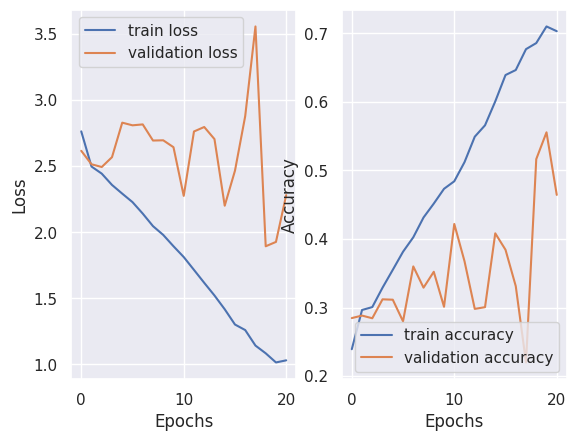

Train Loss: 0.9015, Acc: 0.737630208954215

Val Loss: 2.1497, Acc: 0.4726562574505806
Train Loss: 0.9072, Acc: 0.732503255829215

Val Loss: 2.4568, Acc: 0.3777901828289032
Train Loss: 0.7718, Acc: 0.7802734375

Val Loss: 2.3503, Acc: 0.4628906324505806
Train Loss: 0.7034, Acc: 0.7978515625

Val Loss: 2.4745, Acc: 0.4313616082072258
Train Loss: 0.7259, Acc: 0.7900390625

Val Loss: 2.6409, Acc: 0.4095982164144516
Train Loss: 0.6384, Acc: 0.813232421875

Val Loss: 2.2249, Acc: 0.4963727742433548
Train Loss: 0.5614, Acc: 0.840087890625

Val Loss: 1.9869, Acc: 0.5535714328289032
Train Loss: 0.5221, Acc: 0.849934896454215

Val Loss: 2.0548, Acc: 0.5279017984867096
Train Loss: 0.5768, Acc: 0.8280436201021075

Val Loss: 2.8272, Acc: 0.4034598246216774
Train Loss: 0.6358, Acc: 0.811604818329215

Val Loss: 2.4973, Acc: 0.4559151828289032
Train Loss: 0.5198, Acc: 0.8465983085334301

Val Loss: 2.0387, Acc: 0.5320870578289032
Train Loss: 0.4738, Acc: 0.859212240204215

Val Loss: 2.0006, Acc: 0.5647

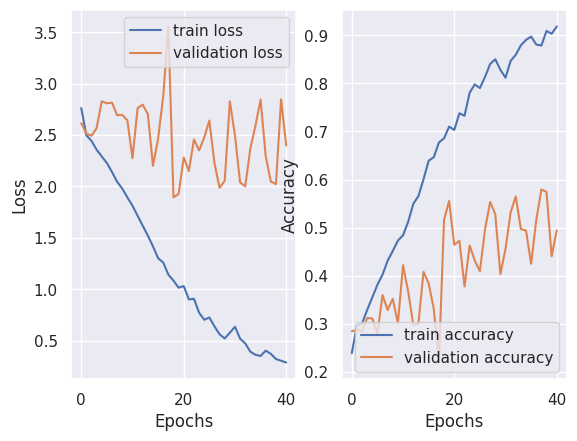

Train Loss: 0.2197, Acc: 0.9352213554084301

Val Loss: 3.4572, Acc: 0.3936941996216774
Train Loss: 0.2053, Acc: 0.9379069022834301

Val Loss: 3.3437, Acc: 0.4034598246216774
Train Loss: 0.1971, Acc: 0.93994140625

Val Loss: 2.2017, Acc: 0.5544084906578064
Train Loss: 0.2178, Acc: 0.9310709647834301

Val Loss: 3.2806, Acc: 0.375
Train Loss: 0.1881, Acc: 0.946126302704215

Val Loss: 2.0244, Acc: 0.6040736734867096
Train Loss: 0.2065, Acc: 0.937093099579215

Val Loss: 2.5274, Acc: 0.5329241156578064
Train Loss: 0.1642, Acc: 0.953450521454215

Val Loss: 1.9109, Acc: 0.623046875
Train Loss: 0.1415, Acc: 0.9615885429084301

Val Loss: 2.5406, Acc: 0.53125
Train Loss: 0.1141, Acc: 0.966796875

Val Loss: 2.4546, Acc: 0.5418526828289032
Train Loss: 0.0931, Acc: 0.971435546875

Val Loss: 2.1026, Acc: 0.5945870578289032
Train Loss: 0.1440, Acc: 0.9554850272834301

Val Loss: 3.5211, Acc: 0.436104916036129
Train Loss: 0.1669, Acc: 0.9486490897834301

Val Loss: 2.3949, Acc: 0.575334832072258
Train Lo

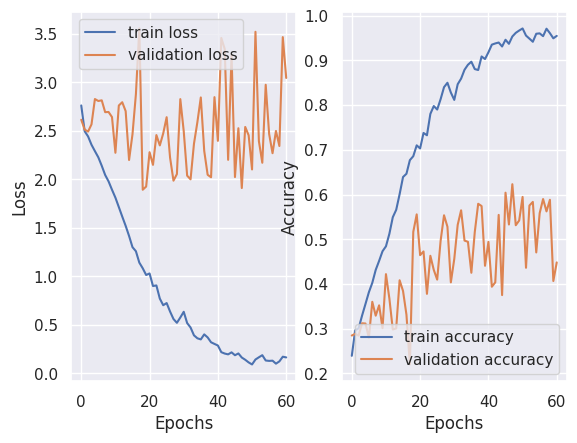

Train Loss: 0.3254, Acc: 0.902099609375

Val Loss: 4.4857, Acc: 0.3233816996216774
Train Loss: 0.1986, Acc: 0.939697265625

Val Loss: 2.7116, Acc: 0.50390625
Train Loss: 0.1428, Acc: 0.953369140625

Val Loss: 2.4121, Acc: 0.529854916036129
Train Loss: 0.0999, Acc: 0.97021484375

Val Loss: 2.4234, Acc: 0.5563616156578064
Train Loss: 0.0621, Acc: 0.9806315116584301

Val Loss: 2.8509, Acc: 0.4930245578289032
Train Loss: 0.0676, Acc: 0.9801432304084301

Val Loss: 2.3011, Acc: 0.60546875
Train Loss: 0.0644, Acc: 0.981201171875

Val Loss: 2.2054, Acc: 0.6049107164144516
Train Loss: 0.0587, Acc: 0.983479818329215

Val Loss: 3.0707, Acc: 0.4508928582072258
Train Loss: 0.0870, Acc: 0.97314453125

Val Loss: 2.5775, Acc: 0.5630580484867096
Train Loss: 0.0794, Acc: 0.975667318329215

Val Loss: 2.2684, Acc: 0.6012834906578064
Train Loss: 0.1641, Acc: 0.950927734375

Val Loss: 2.5086, Acc: 0.551339291036129
Train Loss: 0.2266, Acc: 0.9345703125

Val Loss: 4.6527, Acc: 0.3270089328289032
Train Loss: 

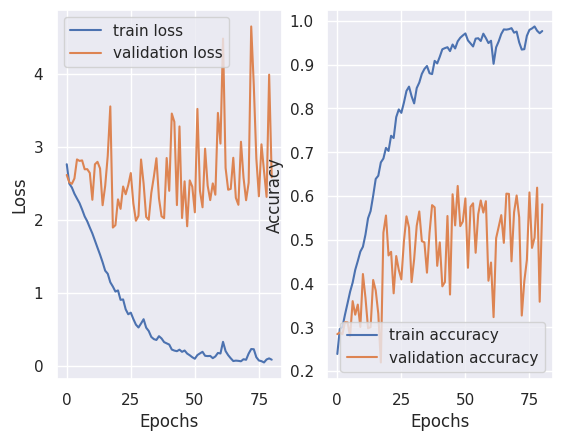

Train Loss: 0.0751, Acc: 0.9769694022834301

Val Loss: 2.9179, Acc: 0.4902343824505806
Train Loss: 0.0780, Acc: 0.974853515625

Val Loss: 2.4040, Acc: 0.590959832072258
Train Loss: 0.1780, Acc: 0.9491373710334301

Val Loss: 3.4775, Acc: 0.422433041036129
Train Loss: 0.2050, Acc: 0.9344889335334301

Val Loss: 3.6450, Acc: 0.451729916036129
Train Loss: 0.1683, Acc: 0.9484049491584301

Val Loss: 5.1398, Acc: 0.2784598246216774
Train Loss: 0.1119, Acc: 0.970703125

Val Loss: 2.9063, Acc: 0.5097656324505806
Train Loss: 0.0862, Acc: 0.9737955741584301

Val Loss: 3.2293, Acc: 0.4782366156578064
Train Loss: 0.0641, Acc: 0.9811197929084301

Val Loss: 2.3124, Acc: 0.6060267984867096
Train Loss: 0.0492, Acc: 0.985595703125

Val Loss: 2.5583, Acc: 0.561662957072258
Train Loss: 0.0511, Acc: 0.988118490204215

Val Loss: 2.3452, Acc: 0.5778459906578064
Train Loss: 0.0833, Acc: 0.9713541679084301

Val Loss: 2.3880, Acc: 0.60546875
Train Loss: 0.0615, Acc: 0.9818522147834301

Val Loss: 2.3630, Acc: 0.5

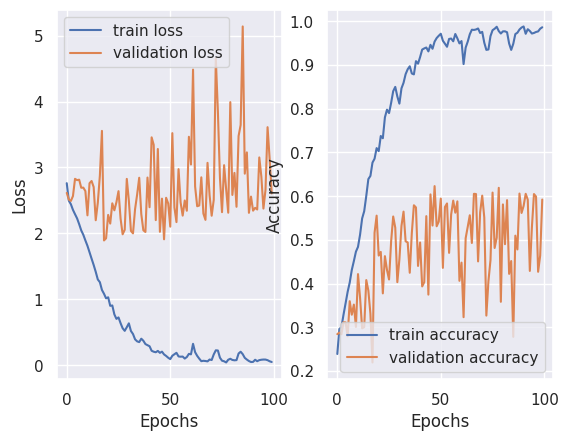

In [46]:
nir_net_freezed, _ = train_resnet_freezed(train_dataset_nir, val_dataset_nir, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.7458, Acc: 0.2431640625

Val Loss: 2.6481, Acc: 0.2845982164144516
Train Loss: 2.4713, Acc: 0.2982584638521075

Val Loss: 2.4591, Acc: 0.2845982164144516
Train Loss: 2.4022, Acc: 0.3160807294771075

Val Loss: 2.7246, Acc: 0.262276791036129
Train Loss: 2.3622, Acc: 0.32796223973855376

Val Loss: 2.4479, Acc: 0.324776791036129
Train Loss: 2.2471, Acc: 0.36140950582921505

Val Loss: 2.4957, Acc: 0.2971540242433548
Train Loss: 2.2014, Acc: 0.3788248701021075

Val Loss: 2.5821, Acc: 0.3727678582072258
Train Loss: 2.1126, Acc: 0.4108072919771075

Val Loss: 2.3636, Acc: 0.3510044664144516
Train Loss: 2.0421, Acc: 0.4283854169771075

Val Loss: 2.3704, Acc: 0.346261166036129
Train Loss: 1.9686, Acc: 0.4457194013521075

Val Loss: 2.1992, Acc: 0.392578125
Train Loss: 1.8743, Acc: 0.47314453125

Val Loss: 2.4445, Acc: 0.412667416036129
Train Loss: 1.7984, Acc: 0.49495442770421505

Val Loss: 2.4369, Acc: 0.404854916036129
Train Loss: 1.6942, Acc: 0.52197265625

Val Loss: 2.2988, Acc: 

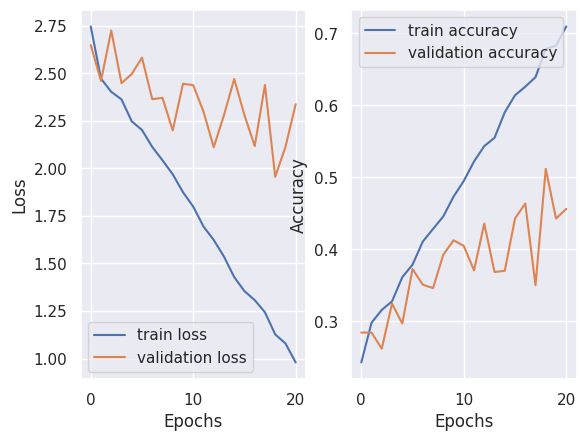

Train Loss: 0.9009, Acc: 0.739095052704215

Val Loss: 2.6011, Acc: 0.3836495578289032
Train Loss: 0.8318, Acc: 0.75390625

Val Loss: 2.1299, Acc: 0.5016741156578064
Train Loss: 0.7481, Acc: 0.781087240204215

Val Loss: 2.4197, Acc: 0.4241071492433548
Train Loss: 0.7019, Acc: 0.79736328125

Val Loss: 2.1205, Acc: 0.4902343824505806
Train Loss: 0.6518, Acc: 0.813557943329215

Val Loss: 2.7762, Acc: 0.4026227742433548
Train Loss: 0.6437, Acc: 0.816162109375

Val Loss: 2.5382, Acc: 0.4291294664144516
Train Loss: 0.6196, Acc: 0.8136393241584301

Val Loss: 2.5278, Acc: 0.4464285746216774
Train Loss: 0.5665, Acc: 0.832600912079215

Val Loss: 2.1202, Acc: 0.5053013414144516
Train Loss: 0.5239, Acc: 0.841796875

Val Loss: 2.3766, Acc: 0.4935825914144516
Train Loss: 0.4269, Acc: 0.8727213554084301

Val Loss: 2.5851, Acc: 0.451171875
Train Loss: 0.5300, Acc: 0.8392740897834301

Val Loss: 2.8999, Acc: 0.3903459832072258
Train Loss: 0.4338, Acc: 0.869873046875

Val Loss: 2.1893, Acc: 0.528459824621

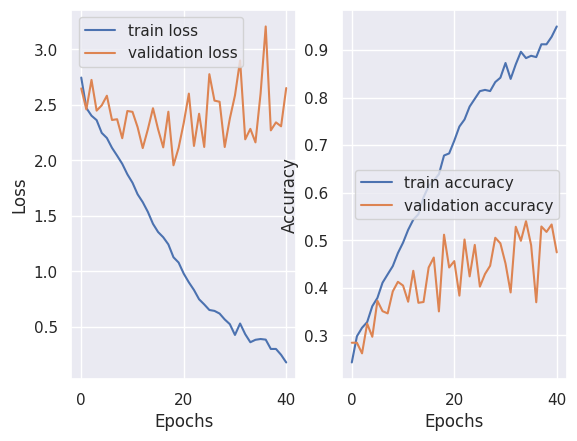

Train Loss: 0.2503, Acc: 0.925048828125

Val Loss: 2.8585, Acc: 0.4768415242433548
Train Loss: 0.2335, Acc: 0.9298502616584301

Val Loss: 2.1430, Acc: 0.5817522406578064
Train Loss: 0.1638, Acc: 0.955322265625

Val Loss: 3.2711, Acc: 0.3964843824505806
Train Loss: 0.1246, Acc: 0.9652506522834301

Val Loss: 2.3572, Acc: 0.5418526828289032
Train Loss: 0.1555, Acc: 0.95703125

Val Loss: 2.1566, Acc: 0.5703125
Train Loss: 0.1354, Acc: 0.960042318329215

Val Loss: 2.3062, Acc: 0.5675223246216774
Train Loss: 0.1460, Acc: 0.9569498710334301

Val Loss: 2.5273, Acc: 0.5309709906578064
Train Loss: 0.2357, Acc: 0.92529296875

Val Loss: 3.1871, Acc: 0.445870541036129
Train Loss: 0.2443, Acc: 0.923583984375

Val Loss: 2.8486, Acc: 0.4821428656578064
Train Loss: 0.1772, Acc: 0.941487630829215

Val Loss: 2.4619, Acc: 0.541015625
Train Loss: 0.1544, Acc: 0.9562174491584301

Val Loss: 2.3283, Acc: 0.5811941996216774
Train Loss: 0.1127, Acc: 0.969563802704215

Val Loss: 2.5455, Acc: 0.5276227742433548
T

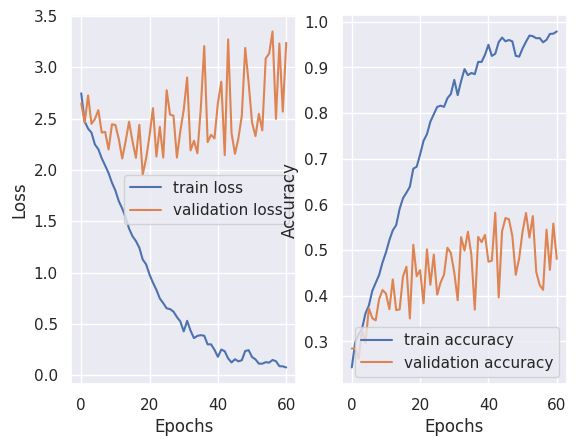

Train Loss: 0.0681, Acc: 0.9818522147834301

Val Loss: 2.6052, Acc: 0.551897332072258
Train Loss: 0.0946, Acc: 0.9765625

Val Loss: 2.4423, Acc: 0.5719866156578064
Train Loss: 0.0597, Acc: 0.9820963554084301

Val Loss: 2.4134, Acc: 0.5887276828289032
Train Loss: 0.0825, Acc: 0.9794108085334301

Val Loss: 2.4672, Acc: 0.56640625
Train Loss: 0.0758, Acc: 0.977132162079215

Val Loss: 2.5005, Acc: 0.5544084906578064
Train Loss: 0.0872, Acc: 0.975341796875

Val Loss: 3.6792, Acc: 0.4327566996216774
Train Loss: 0.0756, Acc: 0.9794108085334301

Val Loss: 2.4316, Acc: 0.6049107164144516
Train Loss: 0.1170, Acc: 0.966878255829215

Val Loss: 2.6512, Acc: 0.537109375
Train Loss: 0.1351, Acc: 0.958984375

Val Loss: 3.2588, Acc: 0.4804687574505806
Train Loss: 0.1614, Acc: 0.9518229179084301

Val Loss: 2.7308, Acc: 0.5465959906578064
Train Loss: 0.2423, Acc: 0.9254557304084301

Val Loss: 3.0354, Acc: 0.4603794664144516
Train Loss: 0.1591, Acc: 0.95068359375

Val Loss: 2.9445, Acc: 0.4874441996216774

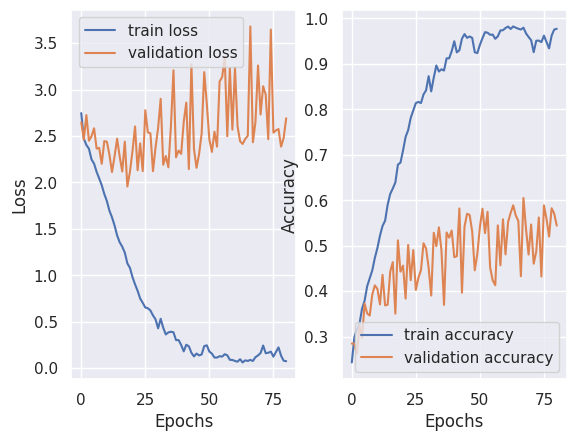

Train Loss: 0.1657, Acc: 0.9545084647834301

Val Loss: 3.0567, Acc: 0.5178571492433548
Train Loss: 0.1879, Acc: 0.940999349579215

Val Loss: 2.6127, Acc: 0.5393415242433548
Train Loss: 0.1378, Acc: 0.959228515625

Val Loss: 2.3952, Acc: 0.6110491156578064
Train Loss: 0.1008, Acc: 0.96826171875

Val Loss: 2.6486, Acc: 0.5239955484867096
Train Loss: 0.0549, Acc: 0.98486328125

Val Loss: 2.5575, Acc: 0.5845424234867096
Train Loss: 0.0286, Acc: 0.992919921875

Val Loss: 2.4943, Acc: 0.6043526828289032
Train Loss: 0.0271, Acc: 0.992024740204215

Val Loss: 2.5178, Acc: 0.5881696492433548
Train Loss: 0.0537, Acc: 0.9864908866584301

Val Loss: 2.7260, Acc: 0.5845424234867096
Train Loss: 0.0702, Acc: 0.9796549491584301

Val Loss: 2.4909, Acc: 0.5731026828289032
Train Loss: 0.0691, Acc: 0.979085287079215

Val Loss: 2.5108, Acc: 0.604631707072258
Train Loss: 0.1682, Acc: 0.94677734375

Val Loss: 3.4425, Acc: 0.4740513414144516
Train Loss: 0.1313, Acc: 0.959716796875

Val Loss: 2.6727, Acc: 0.5630

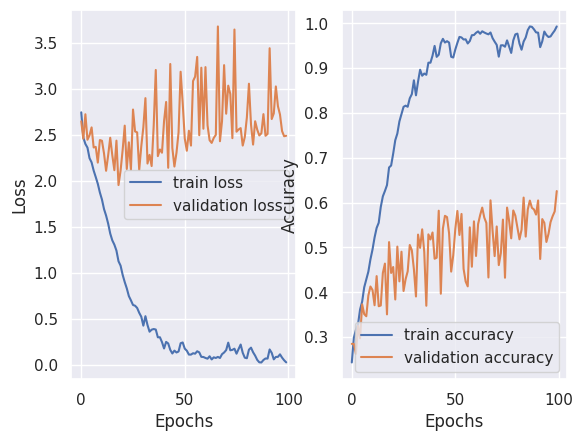

In [47]:
cycle_gan_net_freezed, _ = train_resnet_freezed(train_dataset_cycle_gan, val_dataset_cycle_gan, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.7579, Acc: 0.23543294332921505

Val Loss: 2.6287, Acc: 0.2845982164144516
Train Loss: 2.5037, Acc: 0.28955078125

Val Loss: 2.6401, Acc: 0.2848772332072258
Train Loss: 2.4462, Acc: 0.3077799482271075

Val Loss: 3.0558, Acc: 0.201171875
Train Loss: 2.4069, Acc: 0.312744140625

Val Loss: 2.6449, Acc: 0.29296875
Train Loss: 2.3023, Acc: 0.35408528707921505

Val Loss: 2.9816, Acc: 0.2287946455180645
Train Loss: 2.2221, Acc: 0.37255859375

Val Loss: 2.7777, Acc: 0.2926897332072258
Train Loss: 2.1698, Acc: 0.392578125

Val Loss: 3.0303, Acc: 0.2371651828289032
Train Loss: 2.0990, Acc: 0.4110514326021075

Val Loss: 3.0783, Acc: 0.24609375
Train Loss: 2.0039, Acc: 0.4369303388521075

Val Loss: 3.2339, Acc: 0.3088727742433548
Train Loss: 1.9319, Acc: 0.45515950582921505

Val Loss: 3.0757, Acc: 0.2938058078289032
Train Loss: 1.8629, Acc: 0.4755045576021075

Val Loss: 2.8773, Acc: 0.3217075914144516
Train Loss: 1.7221, Acc: 0.512939453125

Val Loss: 3.1815, Acc: 0.301339291036129
Tr

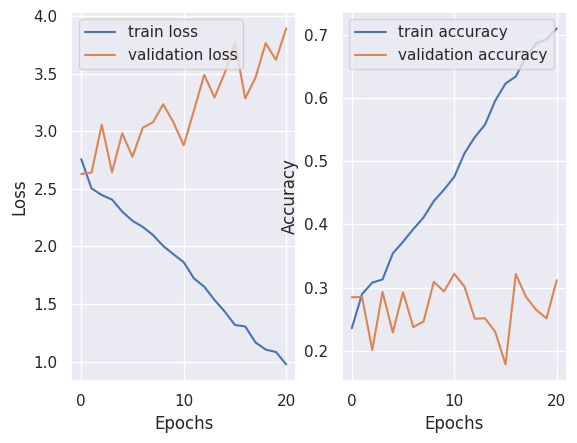

Train Loss: 0.9033, Acc: 0.740478515625

Val Loss: 4.0099, Acc: 0.2307477705180645
Train Loss: 0.7840, Acc: 0.76708984375

Val Loss: 3.8103, Acc: 0.2960379496216774
Train Loss: 0.7116, Acc: 0.795979818329215

Val Loss: 4.3404, Acc: 0.2497209832072258
Train Loss: 0.6672, Acc: 0.796142578125

Val Loss: 3.9552, Acc: 0.2670200914144516
Train Loss: 0.6252, Acc: 0.823811849579215

Val Loss: 4.3590, Acc: 0.2963169664144516
Train Loss: 0.5907, Acc: 0.824951171875

Val Loss: 4.3197, Acc: 0.2564174123108387
Train Loss: 0.5950, Acc: 0.8304850272834301

Val Loss: 4.8449, Acc: 0.2611607164144516
Train Loss: 0.5368, Acc: 0.8470865897834301

Val Loss: 4.3514, Acc: 0.310546875
Train Loss: 0.4657, Acc: 0.860188802704215

Val Loss: 4.2469, Acc: 0.2924107164144516
Train Loss: 0.4010, Acc: 0.8788248710334301

Val Loss: 4.1724, Acc: 0.2885044664144516
Train Loss: 0.4122, Acc: 0.8771158866584301

Val Loss: 4.4659, Acc: 0.2324218787252903
Train Loss: 0.3373, Acc: 0.89892578125

Val Loss: 4.1841, Acc: 0.28404

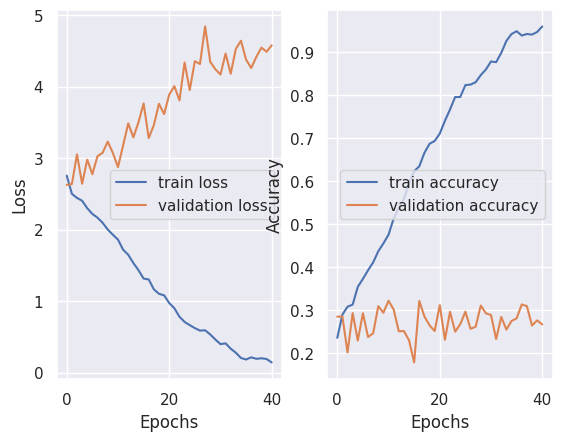

Train Loss: 0.1796, Acc: 0.948079427704215

Val Loss: 4.7899, Acc: 0.2806919664144516
Train Loss: 0.1929, Acc: 0.94482421875

Val Loss: 4.8430, Acc: 0.2985491082072258
Train Loss: 0.2000, Acc: 0.9403483085334301

Val Loss: 4.6230, Acc: 0.309151791036129
Train Loss: 0.1807, Acc: 0.949544271454215

Val Loss: 4.7930, Acc: 0.2979910746216774
Train Loss: 0.2027, Acc: 0.941162109375

Val Loss: 5.0160, Acc: 0.2684151828289032
Train Loss: 0.1179, Acc: 0.9652506522834301

Val Loss: 4.8927, Acc: 0.2921316996216774
Train Loss: 0.1164, Acc: 0.9686686210334301

Val Loss: 4.5884, Acc: 0.2971540242433548
Train Loss: 0.1137, Acc: 0.96533203125

Val Loss: 4.9335, Acc: 0.3083147332072258
Train Loss: 0.1124, Acc: 0.9659830741584301

Val Loss: 4.8767, Acc: 0.28515625
Train Loss: 0.1026, Acc: 0.9720865897834301

Val Loss: 5.1051, Acc: 0.3058035746216774
Train Loss: 0.0862, Acc: 0.978271484375

Val Loss: 4.9487, Acc: 0.3337053582072258
Train Loss: 0.0694, Acc: 0.980224609375

Val Loss: 5.1563, Acc: 0.291573

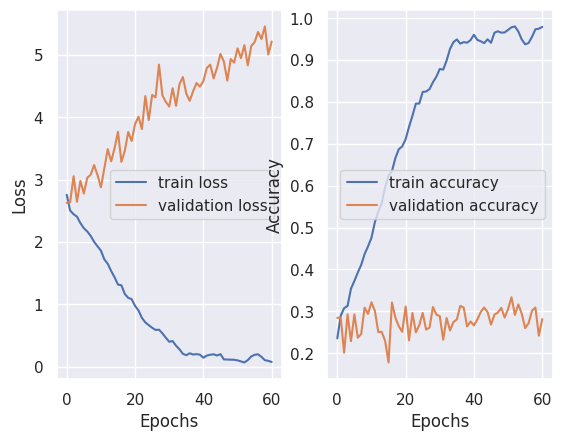

Train Loss: 0.0607, Acc: 0.985188802704215

Val Loss: 4.9423, Acc: 0.2960379496216774
Train Loss: 0.1137, Acc: 0.9694010429084301

Val Loss: 5.3333, Acc: 0.2547433078289032
Train Loss: 0.0887, Acc: 0.9740397147834301

Val Loss: 4.8388, Acc: 0.3244977742433548
Train Loss: 0.0840, Acc: 0.9725748710334301

Val Loss: 4.9141, Acc: 0.3166852742433548
Train Loss: 0.1220, Acc: 0.96728515625

Val Loss: 5.2925, Acc: 0.296875
Train Loss: 0.0671, Acc: 0.9808756522834301

Val Loss: 4.9495, Acc: 0.3236607164144516
Train Loss: 0.0735, Acc: 0.981770833954215

Val Loss: 5.2129, Acc: 0.2720424123108387
Train Loss: 0.1009, Acc: 0.9677734375

Val Loss: 5.3667, Acc: 0.2940848246216774
Train Loss: 0.0597, Acc: 0.984130859375

Val Loss: 4.7337, Acc: 0.298828125
Train Loss: 0.0945, Acc: 0.970947265625

Val Loss: 5.3778, Acc: 0.2960379496216774
Train Loss: 0.1439, Acc: 0.9609375

Val Loss: 5.1813, Acc: 0.305245541036129
Train Loss: 0.0834, Acc: 0.9759928397834301

Val Loss: 5.4690, Acc: 0.296875
Train Loss: 0.

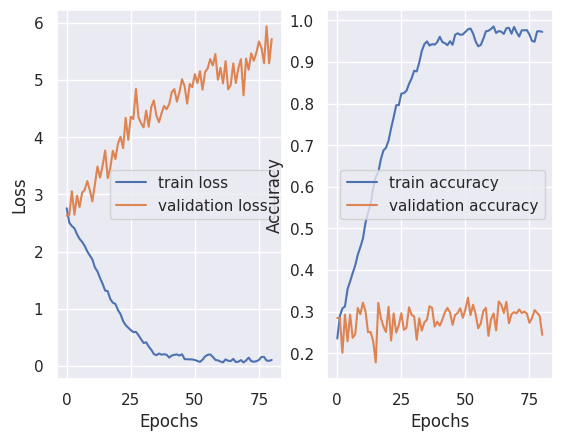

Train Loss: 0.1342, Acc: 0.960286458954215

Val Loss: 5.3394, Acc: 0.3155691996216774
Train Loss: 0.1364, Acc: 0.9591471366584301

Val Loss: 5.7089, Acc: 0.2659040242433548
Train Loss: 0.1115, Acc: 0.961995443329215

Val Loss: 5.0717, Acc: 0.3161272332072258
Train Loss: 0.0847, Acc: 0.974446615204215

Val Loss: 5.4173, Acc: 0.2907366082072258
Train Loss: 0.0774, Acc: 0.974609375

Val Loss: 5.4899, Acc: 0.3147321492433548
Train Loss: 0.0436, Acc: 0.9872233085334301

Val Loss: 5.4626, Acc: 0.2977120578289032
Train Loss: 0.0266, Acc: 0.991943359375

Val Loss: 5.1211, Acc: 0.3370535746216774
Train Loss: 0.0258, Acc: 0.992513021454215

Val Loss: 5.1751, Acc: 0.291573666036129
Train Loss: 0.0560, Acc: 0.984619140625

Val Loss: 5.3095, Acc: 0.3373325914144516
Train Loss: 0.0461, Acc: 0.9864908866584301

Val Loss: 5.6701, Acc: 0.3292410746216774
Train Loss: 0.1114, Acc: 0.9620768241584301

Val Loss: 5.5743, Acc: 0.283203125
Train Loss: 0.0788, Acc: 0.9772135429084301

Val Loss: 5.2031, Acc: 0.

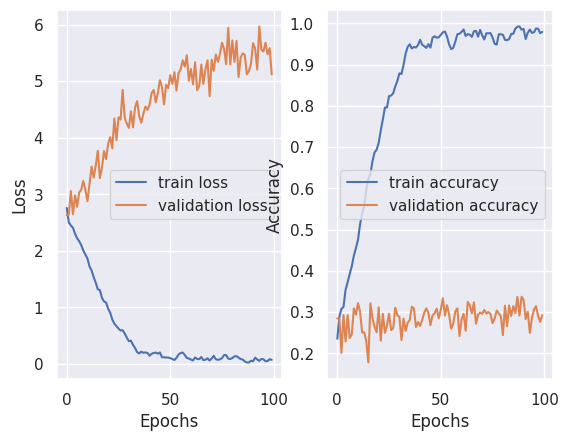

In [48]:
iis_net_freezed, _ = train_resnet_freezed(train_dataset_iis, val_dataset_iis, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.7747, Acc: 0.23600260447710752

Val Loss: 2.6149, Acc: 0.2845982164144516
Train Loss: 2.5391, Acc: 0.282958984375

Val Loss: 2.5570, Acc: 0.2845982164144516
Train Loss: 2.5199, Acc: 0.2939453125

Val Loss: 2.6827, Acc: 0.2349330373108387
Train Loss: 2.5247, Acc: 0.2958170576021075

Val Loss: 2.5716, Acc: 0.2859933078289032
Train Loss: 2.4703, Acc: 0.29541015625

Val Loss: 2.5275, Acc: 0.2737165242433548
Train Loss: 2.4296, Acc: 0.30517578125

Val Loss: 2.5860, Acc: 0.2823660746216774
Train Loss: 2.4072, Acc: 0.30940755270421505

Val Loss: 2.5730, Acc: 0.2982700914144516
Train Loss: 2.3604, Acc: 0.3282877607271075

Val Loss: 2.5993, Acc: 0.2466517873108387
Train Loss: 2.3328, Acc: 0.33333333395421505

Val Loss: 2.4984, Acc: 0.271484375
Train Loss: 2.2962, Acc: 0.34676106786355376

Val Loss: 2.4407, Acc: 0.2965959832072258
Train Loss: 2.2597, Acc: 0.356689453125

Val Loss: 2.4995, Acc: 0.2664620541036129
Train Loss: 2.1671, Acc: 0.384765625

Val Loss: 2.4853, Acc: 0.3069196

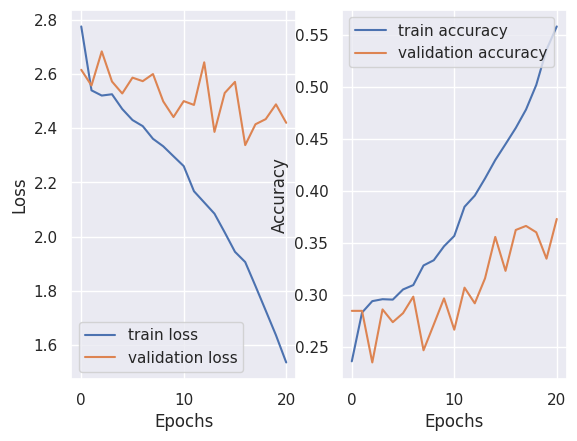

Train Loss: 1.4080, Acc: 0.5924479179084301

Val Loss: 2.6051, Acc: 0.32421875
Train Loss: 1.3506, Acc: 0.6097819022834301

Val Loss: 2.5973, Acc: 0.341796875
Train Loss: 1.2825, Acc: 0.6346842460334301

Val Loss: 2.5486, Acc: 0.3543526828289032
Train Loss: 1.1291, Acc: 0.6725260419771075

Val Loss: 2.5928, Acc: 0.3948102742433548
Train Loss: 1.0778, Acc: 0.687255859375

Val Loss: 2.8808, Acc: 0.3395647332072258
Train Loss: 1.0709, Acc: 0.680908203125

Val Loss: 3.3348, Acc: 0.2815290205180645
Train Loss: 1.0271, Acc: 0.692220052704215

Val Loss: 2.8913, Acc: 0.3864397332072258
Train Loss: 0.8813, Acc: 0.741048177704215

Val Loss: 2.7904, Acc: 0.3839285746216774
Train Loss: 0.7952, Acc: 0.7648111991584301

Val Loss: 3.0337, Acc: 0.3459821492433548
Train Loss: 0.7195, Acc: 0.788330078125

Val Loss: 2.9161, Acc: 0.3920200914144516
Train Loss: 0.6862, Acc: 0.802815755829215

Val Loss: 2.9803, Acc: 0.37109375
Train Loss: 0.5691, Acc: 0.834554037079215

Val Loss: 2.9840, Acc: 0.354073666036

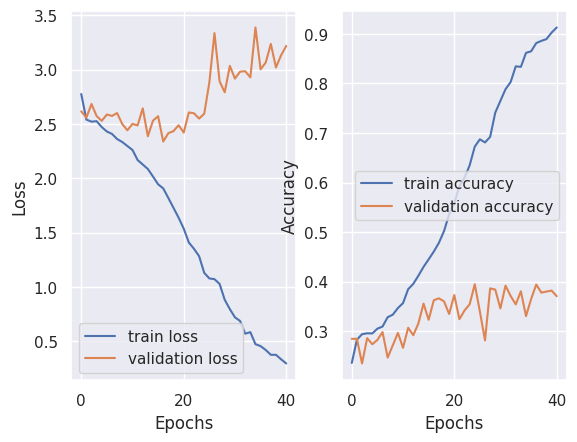

Train Loss: 0.2601, Acc: 0.9235026054084301

Val Loss: 3.4607, Acc: 0.3507254496216774
Train Loss: 0.2585, Acc: 0.9256998710334301

Val Loss: 3.2157, Acc: 0.4151785746216774
Train Loss: 0.2582, Acc: 0.92138671875

Val Loss: 3.5389, Acc: 0.375558041036129
Train Loss: 0.2610, Acc: 0.924397787079215

Val Loss: 3.3061, Acc: 0.4006696492433548
Train Loss: 0.2099, Acc: 0.936360677704215

Val Loss: 3.4152, Acc: 0.380859375
Train Loss: 0.2432, Acc: 0.924153646454215

Val Loss: 3.4191, Acc: 0.4040178582072258
Train Loss: 0.1681, Acc: 0.9564615897834301

Val Loss: 3.2009, Acc: 0.4235491082072258
Train Loss: 0.1049, Acc: 0.973714193329215

Val Loss: 3.3353, Acc: 0.4031808078289032
Train Loss: 0.1334, Acc: 0.959228515625

Val Loss: 3.6732, Acc: 0.397042416036129
Train Loss: 0.1267, Acc: 0.959228515625

Val Loss: 3.3361, Acc: 0.3805803582072258
Train Loss: 0.1275, Acc: 0.9609375

Val Loss: 3.4050, Acc: 0.4255022332072258
Train Loss: 0.1745, Acc: 0.948079427704215

Val Loss: 3.5713, Acc: 0.369698666

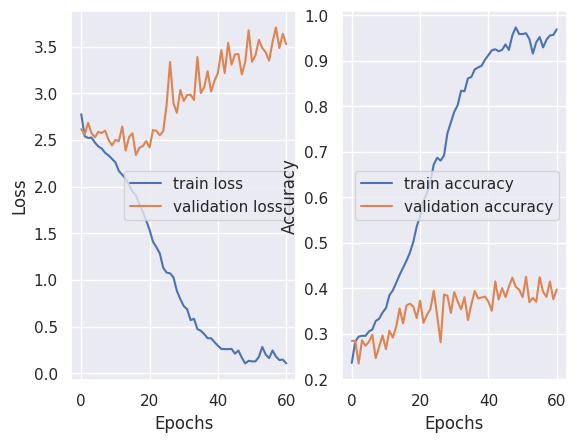

Train Loss: 0.1207, Acc: 0.96484375

Val Loss: 3.5923, Acc: 0.3811383992433548
Train Loss: 0.2412, Acc: 0.9264322929084301

Val Loss: 3.9706, Acc: 0.3219866082072258
Train Loss: 0.1849, Acc: 0.947265625

Val Loss: 3.5161, Acc: 0.3917410746216774
Train Loss: 0.1258, Acc: 0.962972005829215

Val Loss: 3.5554, Acc: 0.4093191996216774
Train Loss: 0.1087, Acc: 0.96484375

Val Loss: 3.8107, Acc: 0.3551897332072258
Train Loss: 0.1492, Acc: 0.9564615897834301

Val Loss: 3.5373, Acc: 0.4260602742433548
Train Loss: 0.1140, Acc: 0.96728515625

Val Loss: 3.4791, Acc: 0.4190848246216774
Train Loss: 0.1922, Acc: 0.9405924491584301

Val Loss: 3.4307, Acc: 0.4207589328289032
Train Loss: 0.0917, Acc: 0.9740397147834301

Val Loss: 3.6294, Acc: 0.3914620578289032
Train Loss: 0.0610, Acc: 0.9842936210334301

Val Loss: 3.5686, Acc: 0.393136166036129
Train Loss: 0.0518, Acc: 0.9892578125

Val Loss: 3.6726, Acc: 0.4168526828289032
Train Loss: 0.0427, Acc: 0.9881998710334301

Val Loss: 3.7314, Acc: 0.414899557

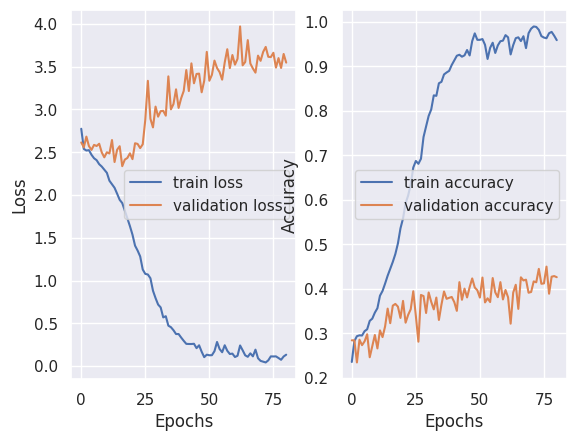

Train Loss: 0.1425, Acc: 0.958089193329215

Val Loss: 3.7539, Acc: 0.3995535746216774
Train Loss: 0.1053, Acc: 0.9669596366584301

Val Loss: 3.5633, Acc: 0.424386166036129
Train Loss: 0.0753, Acc: 0.979573568329215

Val Loss: 3.6807, Acc: 0.4327566996216774
Train Loss: 0.0792, Acc: 0.97900390625

Val Loss: 3.6844, Acc: 0.412667416036129
Train Loss: 0.0380, Acc: 0.988525390625

Val Loss: 3.3534, Acc: 0.4363839328289032
Train Loss: 0.0248, Acc: 0.99365234375

Val Loss: 3.6220, Acc: 0.4383370578289032
Train Loss: 0.0177, Acc: 0.9952799491584301

Val Loss: 3.6342, Acc: 0.443917416036129
Train Loss: 0.0452, Acc: 0.9884440116584301

Val Loss: 3.5889, Acc: 0.4539620578289032
Train Loss: 0.0400, Acc: 0.990234375

Val Loss: 3.7226, Acc: 0.4190848246216774
Train Loss: 0.0390, Acc: 0.9886881522834301

Val Loss: 3.6230, Acc: 0.4171316996216774
Train Loss: 0.1117, Acc: 0.9647623710334301

Val Loss: 4.0528, Acc: 0.4118303582072258
Train Loss: 0.0827, Acc: 0.9737955741584301

Val Loss: 3.8635, Acc: 0

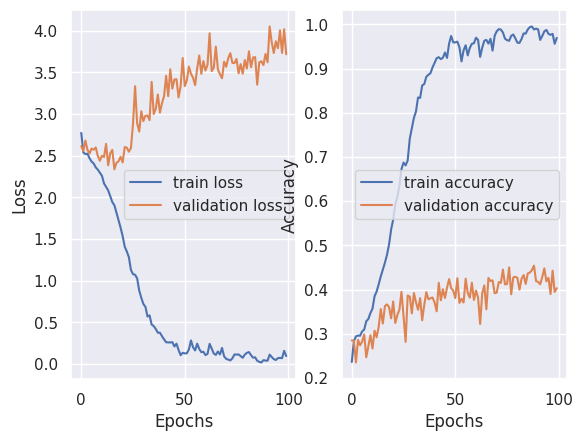

In [49]:
ihfs_net_freezed, _ = train_resnet_freezed(train_dataset_ihfs, val_dataset_ihfs, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.7392, Acc: 0.246826171875

Val Loss: 2.6040, Acc: 0.2845982164144516
Train Loss: 2.4969, Acc: 0.298828125

Val Loss: 2.4852, Acc: 0.2885044664144516
Train Loss: 2.4332, Acc: 0.310302734375

Val Loss: 2.6703, Acc: 0.2633928582072258
Train Loss: 2.4095, Acc: 0.3097330732271075

Val Loss: 2.4234, Acc: 0.3470982164144516
Train Loss: 2.2975, Acc: 0.33919270895421505

Val Loss: 2.5525, Acc: 0.3387276828289032
Train Loss: 2.2136, Acc: 0.36962890625

Val Loss: 2.4400, Acc: 0.333984375
Train Loss: 2.1770, Acc: 0.38826497457921505

Val Loss: 2.4160, Acc: 0.3381696492433548
Train Loss: 2.1117, Acc: 0.4052734375

Val Loss: 2.9432, Acc: 0.2522321455180645
Train Loss: 2.0408, Acc: 0.42220052145421505

Val Loss: 2.3144, Acc: 0.3780691996216774
Train Loss: 1.9479, Acc: 0.44873046875

Val Loss: 2.5652, Acc: 0.3412388414144516
Train Loss: 1.8823, Acc: 0.47200520895421505

Val Loss: 2.2299, Acc: 0.4006696492433548
Train Loss: 1.8191, Acc: 0.48543294332921505

Val Loss: 2.3905, Acc: 0.368861

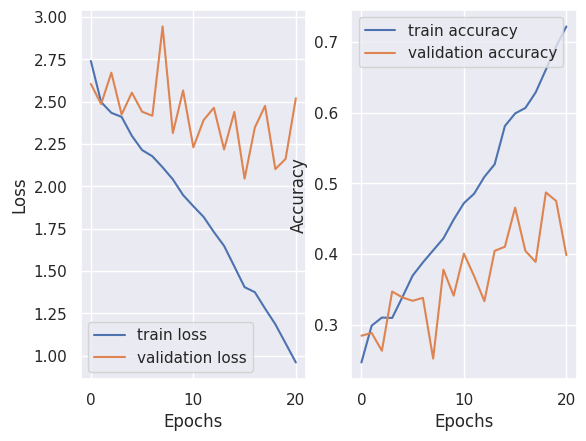

Train Loss: 0.9329, Acc: 0.72705078125

Val Loss: 2.6619, Acc: 0.375558041036129
Train Loss: 0.8461, Acc: 0.74951171875

Val Loss: 2.1913, Acc: 0.4707031324505806
Train Loss: 0.7755, Acc: 0.775146484375

Val Loss: 2.6813, Acc: 0.3610491082072258
Train Loss: 0.7808, Acc: 0.765218099579215

Val Loss: 2.3088, Acc: 0.4483816996216774
Train Loss: 0.6970, Acc: 0.7936197929084301

Val Loss: 2.6435, Acc: 0.3797433078289032
Train Loss: 0.6405, Acc: 0.809651693329215

Val Loss: 2.4566, Acc: 0.459542416036129
Train Loss: 0.6766, Acc: 0.7931315116584301

Val Loss: 2.0102, Acc: 0.5139508992433548
Train Loss: 0.5587, Acc: 0.8339029960334301

Val Loss: 2.6843, Acc: 0.3976004496216774
Train Loss: 0.5568, Acc: 0.838704427704215

Val Loss: 2.5824, Acc: 0.4355468824505806
Train Loss: 0.4731, Acc: 0.8619791679084301

Val Loss: 2.4404, Acc: 0.4631696492433548
Train Loss: 0.4835, Acc: 0.8525390625

Val Loss: 2.7068, Acc: 0.4422433078289032
Train Loss: 0.3881, Acc: 0.883626302704215

Val Loss: 2.7834, Acc: 0

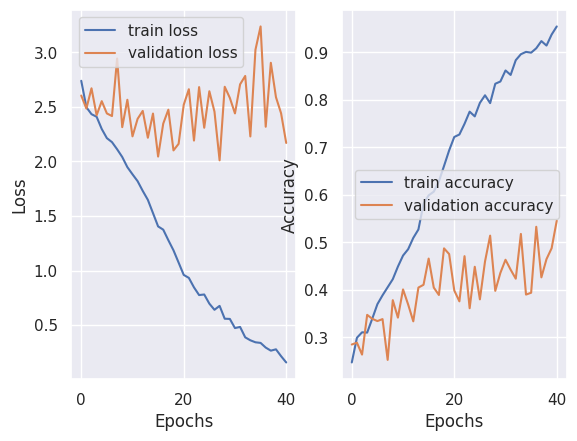

Train Loss: 0.1263, Acc: 0.9657389335334301

Val Loss: 2.4158, Acc: 0.5027901828289032
Train Loss: 0.1301, Acc: 0.963216146454215

Val Loss: 2.2983, Acc: 0.5619419664144516
Train Loss: 0.1084, Acc: 0.968587240204215

Val Loss: 2.5776, Acc: 0.4977678656578064
Train Loss: 0.1497, Acc: 0.957356771454215

Val Loss: 3.5056, Acc: 0.3473772332072258
Train Loss: 0.1522, Acc: 0.954915365204215

Val Loss: 3.7974, Acc: 0.3797433078289032
Train Loss: 0.1423, Acc: 0.957356771454215

Val Loss: 3.3397, Acc: 0.3747209832072258
Train Loss: 0.1724, Acc: 0.9459635429084301

Val Loss: 3.0659, Acc: 0.4676339328289032
Train Loss: 0.2000, Acc: 0.9354654960334301

Val Loss: 2.9085, Acc: 0.5242745578289032
Train Loss: 0.2042, Acc: 0.9404296875

Val Loss: 2.4626, Acc: 0.533203125
Train Loss: 0.1886, Acc: 0.940511068329215

Val Loss: 3.5889, Acc: 0.369698666036129
Train Loss: 0.1582, Acc: 0.9545084647834301

Val Loss: 2.5067, Acc: 0.5309709906578064
Train Loss: 0.1169, Acc: 0.9638671875

Val Loss: 2.6651, Acc: 0

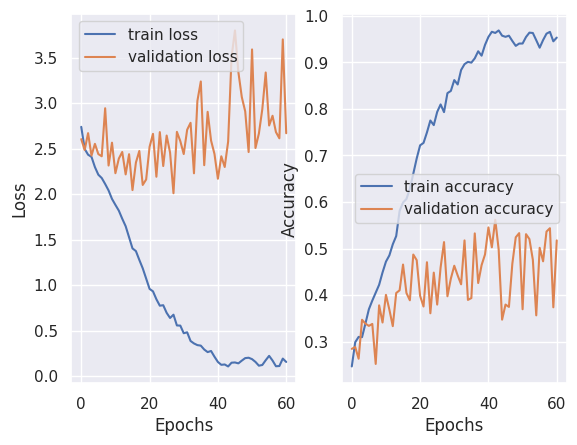

Train Loss: 0.0944, Acc: 0.97509765625

Val Loss: 2.6197, Acc: 0.542131707072258
Train Loss: 0.0902, Acc: 0.971923828125

Val Loss: 2.6919, Acc: 0.5365513414144516
Train Loss: 0.0489, Acc: 0.9884440116584301

Val Loss: 2.6166, Acc: 0.544921875
Train Loss: 0.0647, Acc: 0.982014974579215

Val Loss: 3.5605, Acc: 0.4082031324505806
Train Loss: 0.0724, Acc: 0.9784342460334301

Val Loss: 2.9883, Acc: 0.4550781324505806
Train Loss: 0.0489, Acc: 0.986083984375

Val Loss: 2.7125, Acc: 0.557756707072258
Train Loss: 0.0533, Acc: 0.9860026054084301

Val Loss: 2.6191, Acc: 0.559709832072258
Train Loss: 0.1511, Acc: 0.954427083954215

Val Loss: 3.4434, Acc: 0.4313616156578064
Train Loss: 0.1322, Acc: 0.959228515625

Val Loss: 3.6727, Acc: 0.393136166036129
Train Loss: 0.1161, Acc: 0.9606119804084301

Val Loss: 3.8438, Acc: 0.397042416036129
Train Loss: 0.1519, Acc: 0.953125

Val Loss: 3.3483, Acc: 0.4235491082072258
Train Loss: 0.0747, Acc: 0.9769694022834301

Val Loss: 2.7881, Acc: 0.55078125
Train

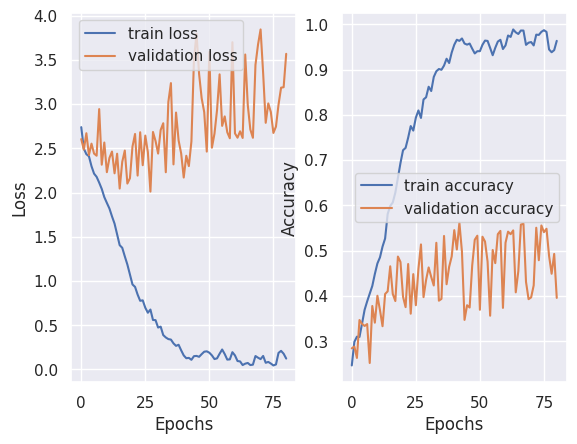

Train Loss: 0.1325, Acc: 0.960205078125

Val Loss: 2.8538, Acc: 0.5343191996216774
Train Loss: 0.1081, Acc: 0.967366537079215

Val Loss: 3.2464, Acc: 0.4330357164144516
Train Loss: 0.1383, Acc: 0.957763671875

Val Loss: 3.4983, Acc: 0.3956473246216774
Train Loss: 0.1093, Acc: 0.967529296875

Val Loss: 3.1781, Acc: 0.4662388414144516
Train Loss: 0.0921, Acc: 0.970296224579215

Val Loss: 2.7645, Acc: 0.5326450914144516
Train Loss: 0.0622, Acc: 0.9828287772834301

Val Loss: 2.7514, Acc: 0.5315290242433548
Train Loss: 0.0448, Acc: 0.989339193329215

Val Loss: 2.9584, Acc: 0.5055803656578064
Train Loss: 0.1403, Acc: 0.958577474579215

Val Loss: 3.7643, Acc: 0.414620541036129
Train Loss: 0.1913, Acc: 0.9396158866584301

Val Loss: 3.2010, Acc: 0.4958147406578064
Train Loss: 0.1743, Acc: 0.9430338554084301

Val Loss: 2.9781, Acc: 0.520647332072258
Train Loss: 0.2431, Acc: 0.930257162079215

Val Loss: 2.9405, Acc: 0.5086495578289032
Train Loss: 0.1034, Acc: 0.9669596366584301

Val Loss: 4.0932,

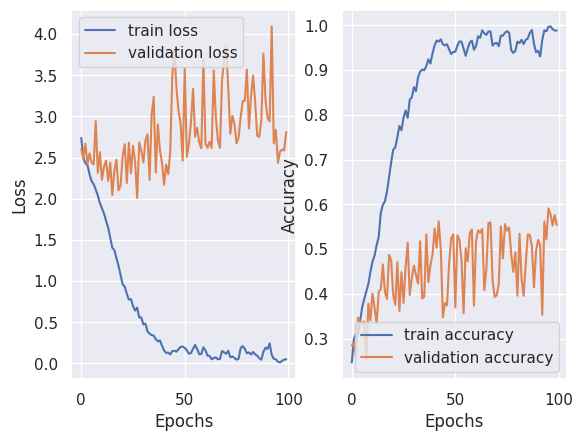

In [50]:
iis_cycle_gan_net_freezed, _ = train_resnet_freezed(train_dataset_iis_cycle_gan, val_dataset_iis_cycle_gan, 1e-4)

In [54]:
def test(model, test_loader, show_images=20):
    model.eval()

    running_acc = 0
    total = 0
    showed = 1
    with torch.no_grad():
        for counter, data in enumerate(test_loader):
            image, target = data['image'].to(device), data['label']
            outputs = model(image).detach().cpu()
            acc = accuracy(outputs, target)

            _, pred = torch.max(torch.log_softmax(outputs, dim=1), dim=1)
            pred_as_string = str(pred.item())

            running_acc += acc

            if showed < show_images and len(pred.flatten()) > 0:
                image = image.squeeze(0)
                image = image.detach().cpu().numpy()
                image = np.transpose(image, (1, 2, 0))
                plt.imshow(image)
                plt.axis('off')

                indices = np.argwhere(target.flatten())
                indices_as_string = " ".join([str(label.item()) for label in indices.flatten()])

                plt.title(f"PREDICTED: {pred_as_string}\nACTUAL: {indices_as_string}")
                plt.show()

                showed += 1

            total += 1

    return running_acc / total

In [55]:
test_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_test
)
test_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_test
)
test_dataset_iis = SerengetiDataset(
    transform=validation_transformations,
    result=iis_serengeti_night_large_test
)
test_dataset_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
test_dataset_ihfs = SerengetiDataset(
    transform=validation_transformations,
    result=ihfs_serengeti_night_large_test,
)
test_dataset_iis_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=iis_cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [56]:
print("NIR", test(nir_net_freezed, DataLoader(test_dataset_nir, batch_size=1, shuffle=False), show_images=0))
print("CycleGAN",
      test(cycle_gan_net_freezed, DataLoader(test_dataset_cycle_gan, batch_size=1, shuffle=False), show_images=0))
print("IIS",
      test(iis_net_freezed, DataLoader(test_dataset_iis, batch_size=1, shuffle=False), show_images=0))
print("IHFS",
      test(ihfs_net_freezed, DataLoader(test_dataset_ihfs, batch_size=1, shuffle=False), show_images=0))
print("IIS CycleGAN",
      test(iis_cycle_gan_net_freezed, DataLoader(test_dataset_iis_cycle_gan, batch_size=1, shuffle=False), show_images=0))

NIR tensor(0.5120)
CycleGAN tensor(0.5100)
IIS tensor(0.3012)
IHFS tensor(0.3635)
IIS CycleGAN tensor(0.4819)
